In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import cv2
import os
import tensorflow as tf
from tensorflow import keras

In [20]:
def load_images_from_folder(folder, img_size):
    images = []
    for filename in os.listdir(folder):
        img = cv2.resize(cv2.imread(os.path.join(folder,filename)), (img_size, img_size))
        if img is not None:
            images.append(img)
    return images

In [21]:
img_size = 227

glioma_train = load_images_from_folder('./Training/glioma_tumor', img_size)
meningioma_train = load_images_from_folder('./Training/meningioma_tumor', img_size)
pituitary_train = load_images_from_folder('./Training/pituitary_tumor', img_size)
control_train = load_images_from_folder('./Training/no_tumor', img_size)

glioma_test = load_images_from_folder('./Testing/glioma_tumor', img_size)
meningioma_test = load_images_from_folder('./Testing/meningioma_tumor', img_size)
pituitary_test = load_images_from_folder('./Testing/pituitary_tumor', img_size)
control_test = load_images_from_folder('./Testing/no_tumor', img_size)

In [22]:
print('Number of glioma images in training set = ' + str(len(glioma_train)))
print('Number of meningioma images in training set = ' + str(len(meningioma_train)))
print('Number of pituitary images in training set = ' + str(len(pituitary_train)))
print('Number of control images in training set = ' + str(len(control_train)))

print('Number of glioma images in test set = ' + str(len(glioma_test)))
print('Number of meningioma images in test set = ' + str(len(meningioma_test)))
print('Number of pituitary images in test set = ' + str(len(pituitary_test)))
print('Number of control images in test set = ' + str(len(control_test)))

Number of glioma images in training set = 826
Number of meningioma images in training set = 822
Number of pituitary images in training set = 827
Number of control images in training set = 395
Number of glioma images in test set = 100
Number of meningioma images in test set = 115
Number of pituitary images in test set = 74
Number of control images in test set = 105


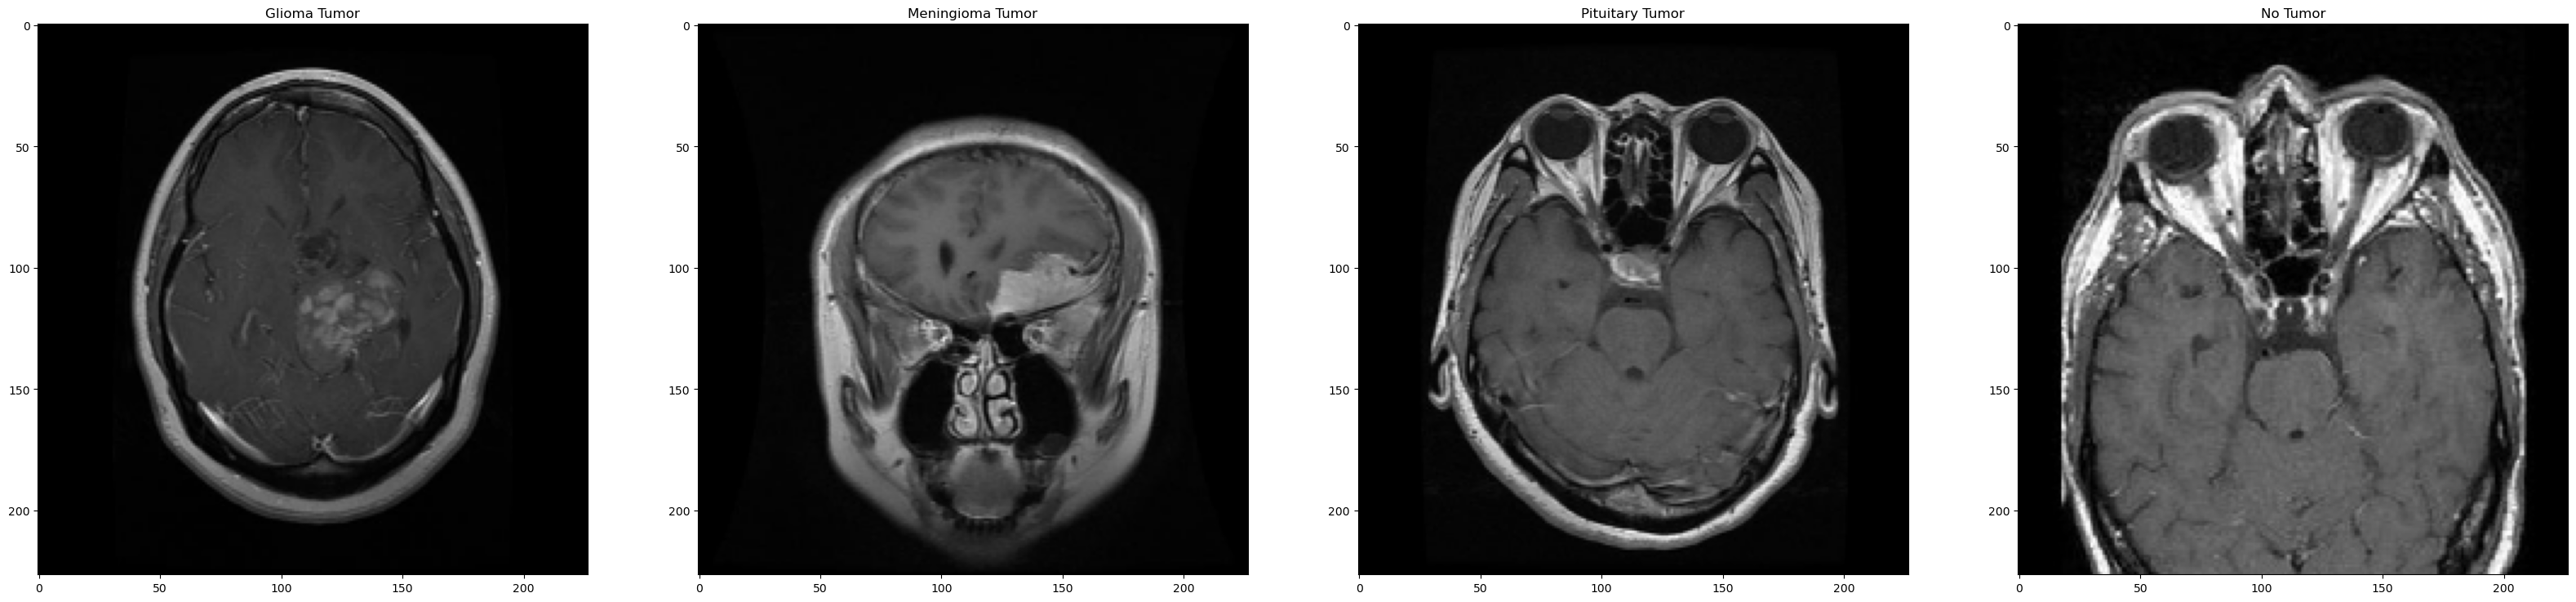

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(40, 40))
ax[0].imshow(glioma_train[0])
ax[0].title.set_text('Glioma Tumor')
ax[1].imshow(meningioma_train[0])
ax[1].title.set_text('Meningioma Tumor')
ax[2].imshow(pituitary_train[0])
ax[2].title.set_text('Pituitary Tumor')
ax[3].imshow(control_train[0])
ax[3].title.set_text('No Tumor')

In [24]:
glioma_train = np.array(glioma_train)
meningioma_train = np.array(meningioma_train)
pituitary_train = np.array(pituitary_train)
control_train = np.array(control_train)

glioma_test = np.array(glioma_test)
meningioma_test = np.array(meningioma_test)
pituitary_test = np.array(pituitary_test)
control_test = np.array(control_test)

In [25]:
# Scale the data to be between 0 and 1

glioma_train = glioma_train.astype('float32')
glioma_train = glioma_train / 255.0
meningioma_train = meningioma_train.astype('float32')
meningioma_train = meningioma_train / 255.0
pituitary_train = pituitary_train.astype('float32')
pituitary_train = pituitary_train / 255.0
control_train = control_train.astype('float32')
control_train = control_train / 255.0

glioma_test = glioma_test.astype('float32')
glioma_test = glioma_test / 255.0
meningioma_test = meningioma_test.astype('float32')
meningioma_test = meningioma_test / 255.0
pituitary_test = pituitary_test.astype('float32')
pituitary_test = pituitary_test / 255.0
control_test = control_test.astype('float32')
control_test = control_test / 255.0


In [26]:
print(glioma_train.shape)
print(meningioma_train.shape)
print(pituitary_train.shape)
print(control_train.shape)

(826, 227, 227, 3)
(822, 227, 227, 3)
(827, 227, 227, 3)
(395, 227, 227, 3)


In [27]:
mri_train = np.concatenate((glioma_train, meningioma_train, pituitary_train, control_train), axis=0)
mri_test = np.concatenate((glioma_test, meningioma_test, pituitary_test, control_test), axis=0)

In [28]:
print('Shape of training set = ' + str(mri_train.shape))
print('Shape of test set = ' + str(mri_test.shape))

Shape of training set = (2870, 227, 227, 3)
Shape of test set = (394, 227, 227, 3)


In [29]:
mri_train_labels = np.zeros(len(mri_train))
mri_train_labels[len(glioma_train):len(glioma_train) + len(meningioma_train)] = 1
mri_train_labels[len(glioma_train) + len(meningioma_train):len(glioma_train) + len(meningioma_train) + len(pituitary_train)] = 2
mri_train_labels[len(glioma_train) + len(meningioma_train) + len(pituitary_train):] = 3

In [30]:
mri_test_labels = np.zeros(len(mri_test))
mri_test_labels[len(glioma_test):len(glioma_test) + len(meningioma_test)] = 1
mri_test_labels[len(glioma_test) + len(meningioma_test):len(glioma_test) + len(meningioma_test) + len(pituitary_test)] = 2
mri_test_labels[len(glioma_test) + len(meningioma_test) + len(pituitary_test):] = 3

In [31]:
X_tt, X_ho, y_tt, y_ho = train_test_split(mri_train.copy(), mri_train_labels, test_size=.1, random_state=400, shuffle=True, stratify=mri_train_labels)

In [35]:
# Implementation of AlexNet

alexnet = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

In [36]:
alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                      

In [38]:
# Compile the neural network
alexnet.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

In [39]:
# Train the model
n_epochs = 50
history_alex = alexnet.fit(X_tt,
                            y_tt,
                            epochs = n_epochs,
                            batch_size = 32,
                            validation_data = (X_ho,y_ho))
          

Epoch 1/50
81/81 [==============================] - 112s 1s/step - loss: 1.9989 - accuracy: 0.5137 - val_loss: 1.4138 - val_accuracy: 0.2927
Epoch 2/50
81/81 [==============================] - 113s 1s/step - loss: 1.1537 - accuracy: 0.6233 - val_loss: 1.7277 - val_accuracy: 0.2927
Epoch 3/50
81/81 [==============================] - 118s 1s/step - loss: 0.8799 - accuracy: 0.6984 - val_loss: 2.1714 - val_accuracy: 0.3101
Epoch 4/50
81/81 [==============================] - 117s 1s/step - loss: 0.7573 - accuracy: 0.7205 - val_loss: 1.7729 - val_accuracy: 0.4530
Epoch 5/50
81/81 [==============================] - 117s 1s/step - loss: 0.6572 - accuracy: 0.7580 - val_loss: 1.3552 - val_accuracy: 0.5540
Epoch 6/50
81/81 [==============================] - 120s 1s/step - loss: 0.5759 - accuracy: 0.7747 - val_loss: 0.7788 - val_accuracy: 0.6969
Epoch 7/50
81/81 [==============================] - 116s 1s/step - loss: 0.5078 - accuracy: 0.8076 - val_loss: 0.5849 - val_accuracy: 0.7561
Epoch 8/50
81

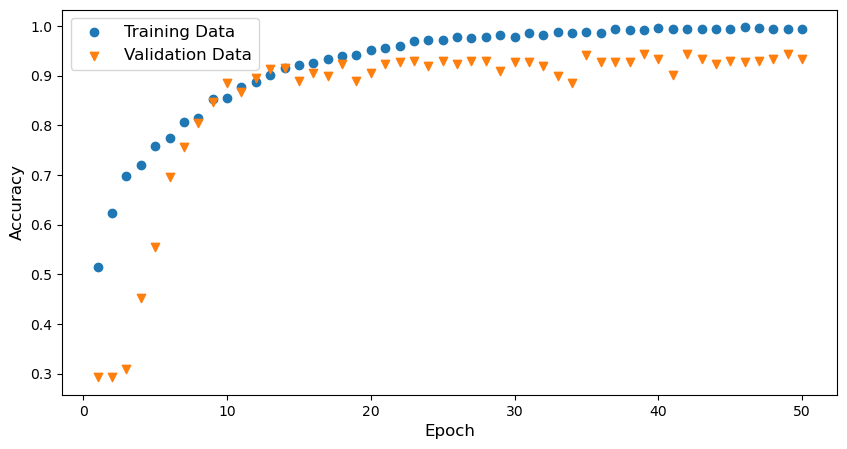

In [40]:
plt.figure(figsize=(10,5))

plt.scatter(range(1,n_epochs+1), 
            history_alex.history['accuracy'], 
            label="Training Data")
plt.scatter(range(1,n_epochs+1), 
            history_alex.history['val_accuracy'], 
            marker='v',
            label="Validation Data")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)


plt.legend(fontsize=12)


plt.show()